In [1]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('max_colwidth',100)

In [2]:
import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7328144358697489259
]


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


In [5]:
# Input Data preprocessing
data_train = pd.read_csv('dataset.csv',usecols=['title','text','label'])
data_train['label'] = data_train['label'].replace('FAKE',1)
data_train['label'] = data_train['label'].replace('REAL',0)
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
texts = []
labels = []

for idx in range(data_train.text.shape[0]):
    text = BeautifulSoup(data_train.title[idx] + " " + data_train.text[idx])
    texts.append(clean_str(text.get_text()))
    labels.append(data_train.label[idx])
    
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['title', 'text', 'label'], dtype='object')
What the raw input data looks like:
                                                                                   title  \
0                                                           You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)   
2                                            Kerry to go to Paris in gesture of sympathy   
3   Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!'   
4                                       The Battle of New York: Why This Primary Matters   

                                                                                                  text  \
0  Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focu...   
1  Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two ...   
2  U.S. Secretary of State John F. Kerry sa

D:\Anaconda2\envs\py35\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file D:\Anaconda2\envs\py35\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
D:\Anaconda2\envs\py35\lib\site-packages\keras\preprocessing\text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 97574 unique tokens.


In [6]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (6335, 1000)
Shape of label tensor: (6335, 2)


In [7]:
# Divide input into train,validation and test set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
x_test = data[int(len(x_val)/2):len(x_val)]
y_test = labels[int(len(y_val)/2):len(y_val)]
x_val = x_val[:int(len(x_val)/2)]
y_val = y_val[:int(len(y_val)/2)]

print('Size of train, validation, and test sets:', len(y_train), len(y_val), len(y_test))

print('Number of real and fake news in training,validation and test sets:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, and test sets: 5068 633 634
Number of real and fake news in training,validation and test sets:
[ 2551.  2517.]
[ 316.  317.]
[ 311.  323.]


In [8]:
# Pre-trained word embeddings
GLOVE_DIR = "E:\\FakeNewsClassifier\\glove" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

Total 400000 word vectors in Glove 6B 100d.


In [18]:
# Simple CNN model
from keras.models import model_from_json
# load json and create model
import os.path
if os.path.isfile('simpleCNN.json'):
    json_file = open('simpleCNN.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("simpleCNN.h5")
    print("Loaded simple model from disk")
    print("Model fitting - simple convolutional neural network")
    model.summary()
    history = pickle.load( open( "simpleHistory", "rb" ) )

Loaded simple model from disk
Model fitting - simple convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         9757500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
____________________________________________________________

In [14]:
if not os.path.isfile('simpleCNN.json'):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool3)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    print("Model fitting - simple convolutional neural network")
    model.summary()
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
              nb_epoch=10, batch_size=128)
    history = hist.history
    
    import pickle
    with open('simpleHistory', 'wb') as file_pi:
        pickle.dump(history, file_pi)

    # serialize model to JSON
    simpleCNN = model.to_json()
    with open("simpleCNN.json", "w") as json_file:
        json_file.write(simpleCNN)
    # serialize weights to HDF5
    model.save_weights("simpleCNN.h5")
    print("Saved simple model to disk")

Model fitting - simple convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         9757500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)       

D:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 5068 samples, validate on 633 samples
Epoch 1/10
5068/5068 [==============================] - 100s 20ms/step - loss: 0.7800 - acc: 0.5695 - val_loss: 0.6062 - val_acc: 0.7836
Epoch 2/10
5068/5068 [==============================] - 96s 19ms/step - loss: 0.5334 - acc: 0.7405 - val_loss: 0.3839 - val_acc: 0.8389
Epoch 3/10
5068/5068 [==============================] - 94s 19ms/step - loss: 0.3685 - acc: 0.8343 - val_loss: 0.3664 - val_acc: 0.8215
Epoch 4/10
5068/5068 [==============================] - 94s 19ms/step - loss: 0.2653 - acc: 0.8917 - val_loss: 0.2842 - val_acc: 0.8863
Epoch 5/10
5068/5068 [==============================] - 94s 19ms/step - loss: 0.2232 - acc: 0.9104 - val_loss: 0.2702 - val_acc: 0.8942
Epoch 6/10
5068/5068 [==============================] - 95s 19ms/step - loss: 0.1510 - acc: 0.9442 - val_loss: 0.2579 - val_acc: 0.9036
Epoch 7/10
5068/5068 [==============================] - 107s 21ms/step - loss: 0.0963 - acc: 0.9674 - val_loss: 0.3349 - val_acc: 0.8815

PermissionError: [Errno 13] Permission denied: '/simpleHistory'

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])


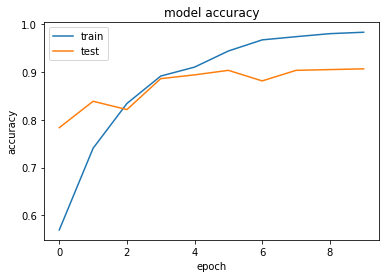

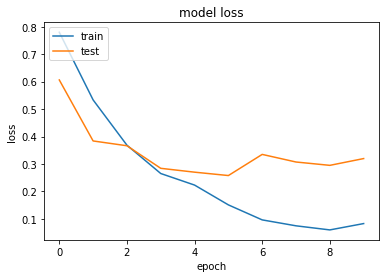

In [21]:
import matplotlib.pyplot as plt
# list all data in history
print(history.keys())
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# applying a more complex convolutional approach
if os.path.isfile('complexCNN.json'):
    json_file = open('complexCNN.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model2 = model_from_json(loaded_model_json)
    # load weights into new model
    model2.load_weights("complexCNN.h5")
    print("Loaded model from disk")
    history2 = pickle.load( open( "complexHistory", "rb" ) )

D:\Anaconda2\envs\py35\lib\site-packages\keras\engine\topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


Loaded model from disk


FileNotFoundError: [Errno 2] No such file or directory: 'complexHistory'

In [24]:
from keras.layers import Dropout

if not os.path.isfile('complexCNN.json'):
    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)
    l_drop = Dropout(0.2)(l_merge)
    l_cov1= Conv1D(128, 5, activation='relu')(l_drop)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model2 = Model(sequence_input, preds)
    model2.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    print("Model fitting - complex convolutional neural network")
    model2.summary()
    hist2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
              nb_epoch=10, batch_size=128)
    history2 = hist2.history
    
    import pickle
    with open('complexHistory', 'wb') as file_pi:
        pickle.dump(history2, file_pi)

    # serialize model to JSON
    complexCNN = model2.to_json()
    with open("complexCNN.json", "w") as json_file:
        json_file.write(complexCNN)
    # serialize weights to HDF5
    model2.save_weights("complexCNN.h5")
    print("Saved complex model to disk")

D:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, activation="relu", kernel_size=3)`
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, activation="relu", kernel_size=4)`
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, activation="relu", kernel_size=5)`
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app


Model fitting - complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    9757500     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 998, 128)     38528       embedding_1[2][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 997, 128)     51328       embedding_1[2][0]                
________________________________________________________

D:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 5068 samples, validate on 633 samples
Epoch 1/10
5068/5068 [==============================] - 285s 56ms/step - loss: 0.8161 - acc: 0.6225 - val_loss: 0.7801 - val_acc: 0.5750
Epoch 2/10
5068/5068 [==============================] - 286s 56ms/step - loss: 0.4272 - acc: 0.8019 - val_loss: 0.4482 - val_acc: 0.7994
Epoch 3/10
5068/5068 [==============================] - 271s 53ms/step - loss: 0.1964 - acc: 0.9199 - val_loss: 0.2111 - val_acc: 0.9321
Epoch 4/10
5068/5068 [==============================] - 269s 53ms/step - loss: 0.1283 - acc: 0.9556 - val_loss: 0.2019 - val_acc: 0.9305
Epoch 5/10
5068/5068 [==============================] - 273s 54ms/step - loss: 0.0814 - acc: 0.9722 - val_loss: 0.2338 - val_acc: 0.9336
Epoch 6/10
5068/5068 [==============================] - 263s 52ms/step - loss: 0.0585 - acc: 0.9809 - val_loss: 0.2426 - val_acc: 0.9289
Epoch 7/10
5068/5068 [==============================] - 247s 49ms/step - loss: 0.0300 - acc: 0.9888 - val_loss: 0.3098 - val_acc: 0

PermissionError: [Errno 13] Permission denied: '/complexHistory'

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])


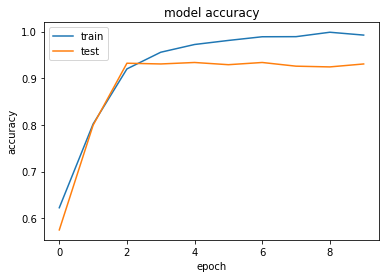

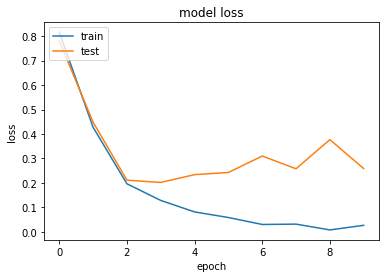

In [27]:
# list all data in history
print(history2.keys())
# summarize history for accuracy
plt.plot(history2['acc'])
plt.plot(history2['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Correct predictions: 633.0
Total number of test examples: 634
Accuracy of model1:  0.998422712933754
Correct predictions: 634.0
Total number of test examples: 634
Accuracy of model2:  1.0


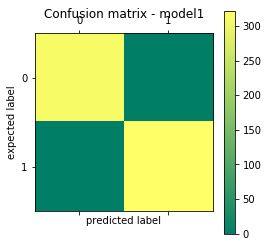

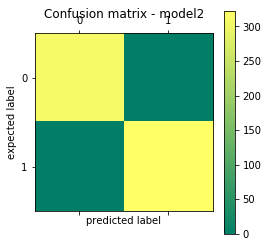

In [36]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.summer, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

#Test model 2
test_preds2 = model2.predict(x_test)
test_preds2 = np.round(test_preds2)
correct_predictions = float(sum(test_preds2 == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = model2.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.summer, interpolation='nearest')
plt.title('Confusion matrix - model2')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [31]:
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0189150837088
Test accuracy: 0.998422712934


In [32]:
model2.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0102347923811
Test accuracy: 1.0
